# 01 — Linear Regression (Hands-on)

Objectives:
- Fit a linear regression model and evaluate performance (R^2, MAE, RMSE)
- Validate assumptions: linearity, independence, homoscedasticity, normality of residuals, and low multicollinearity
- Use diagnostic plots (residual vs. fitted, QQ plot)
- Apply statistical tests (Breusch–Pagan for heteroskedasticity) and VIF for multicollinearity
- Practice feature scaling/engineering and handling outliers

Assumptions to remember:
- Linearity: relationship between features and target is linear
- Independence: observations are independent
- Homoscedasticity: residual variance is constant
- Normality of Errors: residuals are approximately normal (for CI/PI validity)
- Low Multicollinearity: predictors are not highly correlated

Cautions/Data Prep:
- Outliers can distort fit; consider removal/transformations
- Scale features if using regularization or polynomial features
- Handle missing data; linear regression doesn’t natively handle NaNs
- Always check diagnostics after fitting


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

sns.set(style='whitegrid', context='notebook')
np.random.seed(42)


## 1) Load a simple synthetic dataset
We start with a clean linear signal with noise. This is fast and ideal on CPU. Optionally, try California Housing later (slower but realistic).

In [2]:
X, y = make_regression(n_samples=1000, n_features=5, n_informative=5, noise=15.0, random_state=42)
feature_names = [f"x{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['y'] = y
df.head()

,x1,x2,x3,x4,x5,y
0,2.056544,0.606851,0.482688,-1.130888,0.420094,68.683284
1,-0.799192,-0.645964,-0.182896,-0.482744,1.374876,-56.631836
2,1.076007,-0.796026,-0.751969,0.021312,-0.319054,-43.473973
3,-0.103255,-0.828497,1.489863,-1.643189,-1.600904,-81.737419
4,-2.063403,0.503252,-0.645572,-0.317350,-1.661083,-82.025830


Train/validation split, then fit a simple LinearRegression (no regularization).

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df['y'], test_size=0.2, random_state=42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2, mae, rmse

/Users/Srimouli/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.9373723169261087, 12.80265583195794, 15.796794544399042)

Inspect coefficients and intercept. Scale matters when interpreting coefficients; with standardized features, magnitudes are comparable.

In [4]:
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': linreg.coef_}).sort_values('coefficient')
display(pd.Series({'intercept': linreg.intercept_}))
coef_df

intercept   -1.010237
dtype: float64

,feature,coefficient
2,x3,16.576436
4,x5,19.242456
3,x4,24.426282
0,x1,27.557780
1,x2,45.818941


## 2) Residual diagnostics
- Residual vs. predicted: look for randomness (no clear pattern)
- Histogram/QQ plot: check approximate normality
- Homoscedasticity test (Breusch–Pagan)


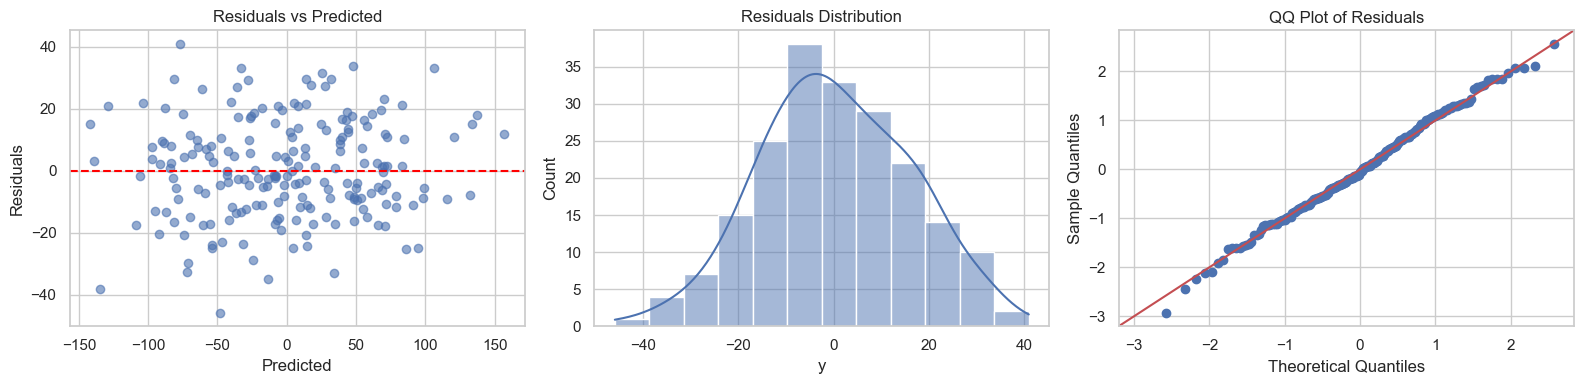

Jarque-Bera p-value: 0.7585
Shapiro-Wilk p-value: 0.8513


In [5]:
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].scatter(y_pred, residuals, alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Predicted')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residuals')

sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title('Residuals Distribution')

sm.ProbPlot(residuals, fit=True).qqplot(line='45', ax=axes[2])
axes[2].set_title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()

# Normality tests (indicative)
jb_stat, jb_p = stats.jarque_bera(residuals)
sw_stat, sw_p = stats.shapiro(residuals)
print(f"Jarque-Bera p-value: {jb_p:.4f}")
print(f"Shapiro-Wilk p-value: {sw_p:.4f}")


Breusch–Pagan test for heteroskedasticity. H0: constant variance (homoscedastic). Small p-value suggests heteroskedasticity.

In [6]:
X_test_const = sm.add_constant(X_test)
ols = sm.OLS(y_test, X_test_const).fit()
bp_test = het_breuschpagan(ols.resid, X_test_const)
labels = ['LM stat', 'LM p-value', 'F stat', 'F p-value']
pd.Series(bp_test, index=labels)

LM stat       9.695378
LM p-value    0.084341
F stat        1.976729
F p-value     0.083753
dtype: float64

## 3) Multicollinearity via VIF
Compute Variance Inflation Factors (VIF). VIF > 5–10 can indicate problematic multicollinearity.

In [7]:
X_train_vif = sm.add_constant(X_train)
vif_df = pd.DataFrame({
    'feature': X_train_vif.columns,
    'VIF': [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
})
vif_df

,feature,VIF
0,const,1.002014
1,x1,1.000383
2,x2,1.006835
3,x3,1.006389
4,x4,1.000619
5,x5,1.000622


Create an intentionally collinear feature and re-evaluate VIF to see it spike.

In [8]:
X_train_collinear = X_train.copy()
X_train_collinear['x_dup'] = X_train_collinear['x1'] * 1.0 + np.random.normal(0, 0.01, size=len(X_train_collinear))
X_train_collinear_const = sm.add_constant(X_train_collinear)
vif_collinear = pd.DataFrame({
    'feature': X_train_collinear_const.columns,
    'VIF': [variance_inflation_factor(X_train_collinear_const.values, i) for i in range(X_train_collinear_const.shape[1])]
})
vif_collinear.sort_values('VIF', ascending=False).head(10)

,feature,VIF
6,x_dup,9196.616393
1,x1,9196.548251
3,x3,1.008179
2,x2,1.006859
5,x5,1.002842
0,const,1.002110
4,x4,1.000714


## 4) Optional: Statsmodels OLS summary
Provides coefficients, standard errors, and more detailed diagnostics. Useful for interpretation when assumptions are (approximately) satisfied.

In [9]:
X_train_const = sm.add_constant(X_train)
ols_train = sm.OLS(y_train, X_train_const).fit()
ols_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     2804.
Date:                Sat, 11 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:55:45   Log-Likelihood:                -3325.1
No. Observations:                 800   AIC:                             6662.
Df Residuals:                     794   BIC:                             6690.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0102      0.549     -1.841      0.066      -2.087       0.067
x1            27.5578      0.583     47.258      0.000      26.413      28.702
x2            45.8189      0.545     84.021      0.000      44.748      46.889
x3            16.5764      0.549     30.182      0.000      15.498      17.655
x4            24.4263      0.544     44.936      0.000      23.359      25.493
x5            19.2425      0.538     35.756      0.000      18.186      20.299
==============================================================================
Omnibus:                        2.008   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.972
Skew:                          -0.041   Prob(JB):                        0.373
Kurtosis:                       3.229   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5) Handling nonlinearity and scaling (brief)
Use polynomial features to capture curvature. Note: increases risk of multicollinearity — use scaling and possibly regularization in practice.

In [10]:
poly_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])
poly_pipe.fit(X_train, y_train)
y_pred_poly = poly_pipe.predict(X_test)
r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)
print({'R2_linear': r2, 'RMSE_linear': rmse, 'R2_poly': r2_poly, 'RMSE_poly': rmse_poly})

{'R2_linear': 0.9373723169261087, 'RMSE_linear': 15.796794544399042, 'R2_poly': 0.9362159021468928, 'RMSE_poly': 15.941970669657945}


/Users/Srimouli/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Exercises
Complete the tasks below. Instructor solution cells are hidden; expand them if needed.

1. Outliers: Inject a few extreme outliers into the training target and re-fit the model. How do metrics and residual plots change? Try trimming or using a robust regression (HuberRegressor) and compare.
2. California Housing: Load `fetch_california_housing()` and repeat the workflow (train/test split, fit, diagnostics). Compare assumptions and performance vs. synthetic data.
3. Feature Engineering: Try adding interaction terms or log-transforming skewed features (on California data). Re-check VIF, residuals, and metrics.


In [11]:
# Exercise 1: Outliers
# TODO: Copy X_train, y_train to new variables, inject outliers into y, fit LinearRegression, and compare metrics/plots.
...

Ellipsis

In [12]:
# Solution 1 (hidden)
from sklearn.linear_model import HuberRegressor

X_train_o = X_train.copy()
y_train_o = y_train.copy()
idx = np.random.choice(len(y_train_o), size=10, replace=False)
y_train_o.iloc[idx] += np.random.normal(300, 50, size=len(idx))

lr_o = LinearRegression().fit(X_train_o, y_train_o)
y_pred_o = lr_o.predict(X_test)
print('Linear with outliers:', r2_score(y_test, y_pred_o), mean_squared_error(y_test, y_pred_o, squared=False))

hub = HuberRegressor().fit(X_train_o, y_train_o)
y_pred_h = hub.predict(X_test)
print('Huber (robust):', r2_score(y_test, y_pred_h), mean_squared_error(y_test, y_pred_h, squared=False))


Linear with outliers: 0.9338683304245726 16.232691710858635
Huber (robust): 0.9373353290101667 15.801458650071215


/Users/Srimouli/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/Srimouli/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# Exercise 2: California Housing
# TODO: Load dataset, fit LinearRegression, run diagnostics (residual plot, QQ, BP test, VIF), compare to synthetic.
...

Ellipsis

California R2, RMSE: 0.5757877060324511 0.7455813830127761


/Users/Srimouli/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


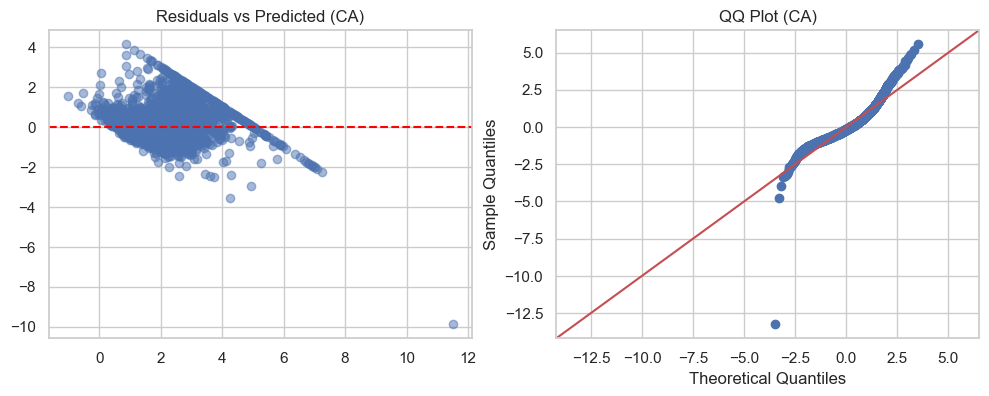

BP p-value: 0.0 0.0


,feature,VIF
0,const,16901.024982
7,Latitude,9.206134
8,Longitude,8.875984
3,AveRooms,7.917240
4,AveBedrms,6.609200
1,MedInc,2.539815
2,HouseAge,1.237337
5,Population,1.134824
6,AveOccup,1.009733


In [14]:
# Solution 2 (hidden)
cal = fetch_california_housing()
Xc = pd.DataFrame(cal.data, columns=cal.feature_names)
yc = pd.Series(cal.target, name='MedHouseVal')
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)
lr_c = LinearRegression().fit(Xc_train, yc_train)
yc_pred = lr_c.predict(Xc_test)
print('California R2, RMSE:', r2_score(yc_test, yc_pred), mean_squared_error(yc_test, yc_pred, squared=False))

resid_c = yc_test - yc_pred
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].scatter(yc_pred, resid_c, alpha=0.5)
axes[0].axhline(0, color='red', ls='--')
axes[0].set_title('Residuals vs Predicted (CA)')
sm.ProbPlot(resid_c, fit=True).qqplot(line='45', ax=axes[1])
axes[1].set_title('QQ Plot (CA)')
plt.show()

Xc_test_const = sm.add_constant(Xc_test)
bp = het_breuschpagan(resid_c, Xc_test_const)
print('BP p-value:', bp[1], bp[3])

Xc_train_const = sm.add_constant(Xc_train)
vif_ca = pd.DataFrame({
    'feature': Xc_train_const.columns,
    'VIF': [variance_inflation_factor(Xc_train_const.values, i) for i in range(Xc_train_const.shape[1])]
})
vif_ca.sort_values('VIF', ascending=False)


In [15]:
# Exercise 3: Feature Engineering
# TODO: Try interactions or log-transform certain features (e.g., log(1 + MedInc)) and compare metrics/assumptions.
...

Ellipsis

In [16]:
# Solution 3 (hidden)
Xc2 = Xc.copy()
if 'MedInc' in Xc2.columns:
    Xc2['log_MedInc'] = np.log1p(Xc2['MedInc'])
if set(['AveRooms','AveBedrms']).issubset(Xc2.columns):
    Xc2['Rooms_per_Bedroom'] = Xc2['AveRooms'] / (Xc2['AveBedrms'] + 1e-6)

Xc2_train, Xc2_test, yc_train, yc_test = train_test_split(Xc2, yc, test_size=0.2, random_state=42)
lr2 = LinearRegression().fit(Xc2_train, yc_train)
yc2_pred = lr2.predict(Xc2_test)
print('Engineered R2, RMSE:', r2_score(yc_test, yc2_pred), mean_squared_error(yc_test, yc2_pred, squared=False))


Engineered R2, RMSE: 0.595782335680144 0.7277983625210388


/Users/Srimouli/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Wrap-up
Checklist for linear regression practice:
- [ ] Split data properly and avoid leakage
- [ ] Fit baseline model and record metrics
- [ ] Plot residuals vs. predicted; look for patterns
- [ ] Check residual normality (hist/QQ), run normality tests if needed
- [ ] Test homoscedasticity (e.g., Breusch–Pagan)
- [ ] Compute VIF for multicollinearity
- [ ] Revisit outliers, transformations, and features as needed
